# CNN LSTM grayscale image+PR model

In [1]:
import gc
import os
import sys
import cv2
import json
import math
import pickle
import random
import platform
import numpy as np
import pandas as pd
import multiprocessing
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

In [2]:
print(torch.__version__)
print(pl.__version__)

1.11.0
1.6.1


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)
cpu_count = multiprocessing.cpu_count()
print('CPU count:', cpu_count)
platform_os = "windows" if platform.system() == "Windows" else "linux"
print("Platform:", platform_os)

# Pytorch Dataloader can't handle n_workers > 0 on windows due to bugs
N_WORKERS = 0 if platform_os=="windows" else cpu_count
print(f"number of workers: {N_WORKERS}")

device: cuda
CPU count: 16
Platform: windows
number of workers: 0


# Constants

In [40]:
# change to appropriate location
TRAIN_FOLDER = "../../3dmodel/test_4_episode_"
MODEL_NAME = "CNN_gray_img-PR-to-PR"
MODEL_STATE_FOLDER = f"../model_states/{MODEL_NAME}"
RESULT_FOLDER = f"../../results/{MODEL_NAME}"
TRAIN_RESULT_FOLDER = f"../train_results/{MODEL_NAME}"
TEST_RESULT_FOLDER = f"../test_results/{MODEL_NAME}"
SAVE_RESULTS = True

In [5]:
if not os.path.exists(MODEL_STATE_FOLDER):
    os.mkdir(MODEL_STATE_FOLDER)
if not os.path.exists(TRAIN_RESULT_FOLDER):
    os.mkdir(TRAIN_RESULT_FOLDER)
if not os.path.exists(TEST_RESULT_FOLDER):
    os.mkdir(TEST_RESULT_FOLDER)
if not os.path.exists(RESULT_FOLDER):
    os.mkdir(RESULT_FOLDER)

In [6]:
FRAMES_IN = 10
FRAMES_OUT = 60

N_EPISODES = 540
FRAMES_PER_EPISODE = 400

TRAIN_SIZE = 0.8
NUM_EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

CUDA = device.type == 'cuda'

# Load data from episodes

In [7]:
# view first episode 's datapoints
filename = TRAIN_FOLDER + "1/"
data = []
labels = json.load(open(filename+"labels_0.json"))
ep1 = pd.DataFrame(labels)
ep1 = ep1.transpose()
ep1.rename(columns = {0:'pitch', 1:'roll'}, inplace=True)
ep1.head(5)

,pitch,roll
0,15.915869,2.358416
1,14.295925,1.700391
2,6.213590,1.611325
3,1.235337,6.175461
4,1.341678,3.695468


In [8]:
img_tensors_array = []
filename = TRAIN_FOLDER + "1/"
for index, row in ep1.iterrows():
    img = cv2.imread(filename + str(index) + ".png", cv2.IMREAD_GRAYSCALE)
    img_tensors_array.append(torch.Tensor(img))

len(img_tensors_array), img_tensors_array[0].shape

(400, torch.Size([54, 96]))

In [9]:
# Function to normalize pixels
def norm_pixel(x):
    x = x.astype('float32')
    return (x*2)/255-1

# Function to denormalize pixels
def denorm_pixel(x):
    x = x.astype('float32')
    return (x+1)*255/2

In [10]:
# Function to normalize pitch and roll angles
def norm_pr(x, min = -90.0, max = 90.0):
    return ((x - min) * 2) / (max - min) - 1

# Function to denormalize pitch and roll angles
def denorm_pr(x, min = -90.0, max = 90.0):
    return ((x + 1) * (max - min))/2 + min

In [11]:
# load all data
episodes_data = []
img_tensors_array = []

for ep in tqdm(range(1, N_EPISODES+1)):
    folder = TRAIN_FOLDER + str(ep) + "/"
    filename = folder + "labels_0.json"
    labels = json.load(open(filename))
    for i in labels:
        # load image, normalize and convert to tensor
        img = cv2.imread(folder + str(i) + ".png", cv2.IMREAD_GRAYSCALE)
        img = norm_pixel(img)
        img_tensors_array.append(torch.Tensor(img))

        # pitch and roll is read with labels[i] as [pitch, roll]
        episodes_data.append(labels[i])

# verify that 216.000 images were loaded
len(img_tensors_array), img_tensors_array[0].shape

  0%|          | 0/540 [00:00<?, ?it/s]

(216000, torch.Size([54, 96]))

In [12]:
# build dataframe with pitch and roll, cast as float and normalize
p_r_df = pd.DataFrame(episodes_data)
p_r_df.rename(columns = {0:'pitch', 1:'roll'}, inplace=True)
p_r_df = p_r_df.astype({"pitch": float, "roll": float})
p_r_df['pitch'] = p_r_df['pitch'].apply(lambda x : norm_pr(x))
p_r_df['roll'] = p_r_df['roll'].apply(lambda x : norm_pr(x))
print(p_r_df.shape)
p_r_df.head(5)

(216000, 2)


,pitch,roll
0,0.176843,0.026205
1,0.158844,0.018893
2,0.069040,0.017904
3,0.013726,0.068616
4,0.014908,0.041061


In [13]:
# tranform the array of image tensors into one tensor of shape: (samples, height, width, channels)
img_tensor = torch.stack(img_tensors_array)
img_tensor_array = None # free this memory
img_tensor.shape

torch.Size([216000, 54, 96])

In [14]:
# clear memory
gc.collect()

18

# Create input and output sequences

In [15]:
# function to create sequences with image and PR inputs to PR outputs
def create_sequences(
        input_data: pd.DataFrame, 
        input_images,
        input_feature_columns,
        output_target_columns, 
        input_sequence_length=FRAMES_IN, 
        output_sequence_length=FRAMES_OUT,  
        episode_length = FRAMES_PER_EPISODE, 
        n_episodes = N_EPISODES
    ):
    input_sequences= []
    output_sequences= []

    # make sequences per episode, one sequence can only hold data of one and the same episode!
    for n in tqdm(range(n_episodes)):

        for l in range(episode_length-output_sequence_length-input_sequence_length+1):
            
            i = l+(n*episode_length)

            # grab image input tensors from list with img_tensors
            img_sequence = input_images[i:i+input_sequence_length]
            pr_sequence = input_data[i:i+input_sequence_length]

            # grab pr output sequence from dataframe
            target_position = i + input_sequence_length
            target = input_data.iloc[target_position:target_position+output_sequence_length].transpose()

            input_sequences.append((img_sequence, pr_sequence))
            output_sequences.append(target)

    return input_sequences, output_sequences

In [16]:
# use images to predict pitch and roll
input_features = ["pitch", "roll"]
output_features = ["pitch", "roll"]
input_sequences, output_sequences = create_sequences(p_r_df, img_tensor, input_features, output_features)

  0%|          | 0/540 [00:00<?, ?it/s]

In [17]:
len(input_sequences), input_sequences[0][0].shape , input_sequences[0][1].shape, output_sequences[0].shape

(178740, torch.Size([10, 54, 96]), (10, 2), (2, 60))

In [18]:
# first input sequence
input_sequences[0][1].head()

,pitch,roll
0,0.176843,0.026205
1,0.158844,0.018893
2,0.069040,0.017904
3,0.013726,0.068616
4,0.014908,0.041061


In [19]:
# Grab random subsets from all sequences for training and test data (without overlapping data)
data_size = len(input_sequences)
data_indices = list(np.arange(0, data_size, 1))

# train indices are random sample from all data indices
random.seed(42)
train_size = int(TRAIN_SIZE * data_size)
train_indices = random.sample(data_indices, train_size)

# test indices are the difference of all data indices and train indices
test_indices = list(set(data_indices) - set(train_indices))

random.shuffle(train_indices)
random.shuffle(test_indices)

print((len(train_indices) + len(test_indices)) <= data_size)
print("Training size:", len(train_indices),"| Test size:", len(test_indices))
print(train_indices[:10])
print(test_indices[:10])

True
Training size: 142992 | Test size: 35748
[119880, 89313, 123388, 10060, 133332, 8934, 114966, 33719, 86970, 163133]
[94107, 109713, 113597, 165722, 172355, 161915, 37020, 160369, 129426, 13017]


In [20]:
train_sequences = []
test_sequences = []

for idx in tqdm(train_indices):
    seq = input_sequences[idx]
    label = output_sequences[idx]
    train_sequences.append((seq,label))

for idx in tqdm(test_indices):
    seq = input_sequences[idx]
    label = output_sequences[idx]
    test_sequences.append((seq,label))

print((len(train_sequences) + len(test_sequences)) <= len(output_sequences))
print(len(train_sequences), train_sequences[0][0][0].shape, train_sequences[0][0][1].shape, train_sequences[0][1].shape) 
print(len(test_sequences), test_sequences[0][0][0].shape, test_sequences[0][0][1].shape, test_sequences[0][1].shape)

  0%|          | 0/142992 [00:00<?, ?it/s]

  0%|          | 0/35748 [00:00<?, ?it/s]

True
142992 torch.Size([10, 54, 96]) (10, 2) (2, 60)
35748 torch.Size([10, 54, 96]) (10, 2) (2, 60)


## Pytorch Dataset and DataLoader

In [21]:
class PRDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        (img_sequence, pr_sequence), labels = self.sequences[index]

        return dict(
            input_img_sequence = img_sequence.unsqueeze(1),
            input_pr_sequence = torch.Tensor(pr_sequence.to_numpy()),
            output_sequence = torch.Tensor(labels.to_numpy())
        )

In [22]:
class PRDataModule(pl.LightningDataModule):
    def __init__(self, train_sequences, test_sequences, batchsize = BATCH_SIZE):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batchsize = batchsize

    # turns normal list object into Dataset object
    def setup(self):
        self.train_dataset = PRDataset(self.train_sequences)
        self.test_dataset = PRDataset(self.test_sequences)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size = self.batchsize,
            shuffle = False,
            num_workers=N_WORKERS,
            pin_memory = True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = self.batchsize,
            shuffle = False,
            num_workers=N_WORKERS,
            pin_memory = True,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = 1,
            shuffle = False,
            num_workers=N_WORKERS,
        )

In [23]:
data_module = PRDataModule(train_sequences, test_sequences, BATCH_SIZE)
data_module.setup()

In [24]:
# batch size first
for batch in data_module.train_dataloader():
    print(batch["input_img_sequence"].shape)
    print(batch["input_pr_sequence"].shape)
    print(batch["output_sequence"].shape)
    break

torch.Size([64, 10, 1, 54, 96])
torch.Size([64, 10, 2])
torch.Size([64, 2, 60])


## CNN Model

In [25]:
class CNN_encoder(nn.Module):

    def __init__(self, channels=3):
        super(CNN_encoder, self).__init__()

        # outputs a tensor of shape (batch, out_channels, h/2/2, w/2/2)
        self.cnn_encoder = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=8, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
    
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

    def forward(self, img_sequence, pr_sequence, batch_size):
        # x is of shape (batch, seq_lenth, channels, height, width)
        # iterate over the sequence and encode a feature vector for each image
        img_features = [self.cnn_encoder(img_sequence[:,i,:,:,:]) for i in range(img_sequence.size(1))]
        
        # flatten individual feature vectors in img_features to (batch, n)
        img_features = [img.reshape(batch_size, -1) for img in img_features]

        # append pitch and roll to the end of each img feature vector
        # pr_sequence is of shape (batch, seq_lenth, 2)
        # TODO: change to other operation because cat is very slow on GPU
        img_features = [torch.cat((torch.tanh(img_features[i]), pr_sequence[:,i,:]), dim=1) for i in range(len(img_features))]

        # convert list of vectors into tensor of shape: (batch, len(img_features), features)
        img_features = torch.stack(img_features, 1)

        # reshape into (batch, 1, n*features)
        img_features = img_features.reshape(batch_size, -1).unsqueeze(1)

        return img_features

In [26]:
# get the first batch out of the dataloader for testing purposes
for batch in data_module.train_dataloader():
    img_train = batch["input_img_sequence"]
    pr_train = batch["input_pr_sequence"]
    y_train = batch["output_sequence"]
    break

In [27]:
model = CNN_encoder(channels=1)
img_features = model.forward(img_train, pr_train, BATCH_SIZE)
img_features.shape

torch.Size([64, 1, 49940])

In [28]:
# ENCODER
class LSTM_encoder(nn.Module):
    def __init__(self, input_size, hidden_size=1024, num_layers=1):
       
        super(LSTM_encoder, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_size = input_size*4994

        self.encoder_lstm = nn.LSTM(
            input_size=input_size*4994, 
            hidden_size=hidden_size, 
            num_layers=num_layers,
            batch_first=True,
        )

    def forward(self, input_seq):

        ouputs, hidden = self.encoder_lstm(input_seq)
        
        return ouputs, hidden

In [29]:
model = LSTM_encoder(FRAMES_IN)
output, hidden = model.forward(img_features)
output.shape

torch.Size([64, 1, 1024])

In [30]:
# DECODER
class Decoder(nn.Module):
    def __init__(self, output_size, hidden_size=1024, num_layers=1):
        super(Decoder, self).__init__()

        self.output_size = output_size*2
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.decoder_lstm = nn.LSTM(
            input_size = hidden_size, 
            hidden_size = hidden_size,
            num_layers = num_layers, 
            batch_first = True
        )

        self.decoder_fc_1 = nn.Linear(hidden_size, int(hidden_size/2))
        self.decoder_fc_2 = nn.Linear(int(hidden_size/2), output_size*2)

    def forward(self, x_input, hidden):

        outputs, hidden = self.decoder_lstm(x_input, hidden)

        outputs = self.decoder_fc_1(outputs)
        outputs = torch.tanh(self.decoder_fc_2(outputs))

        return outputs, hidden

In [31]:
model = Decoder(FRAMES_OUT)
out, hidden = model.forward(output, hidden)
out.shape

torch.Size([64, 1, 120])

In [32]:
# Wrapper class for encoder and decoder
class CNN_LSTM_seq2seq(nn.Module):
    def __init__(self, encoder_input_size, output_size, channels = 3, hidden_size = 1024):
        super(CNN_LSTM_seq2seq, self).__init__()

        self.input_size = encoder_input_size
        self.output_size = output_size
        self.hidden_size = hidden_size

        self.cnn_encoder = CNN_encoder(channels=channels)
        self.lstm_encoder = LSTM_encoder(input_size = encoder_input_size, hidden_size = hidden_size)
        self.decoder = Decoder(output_size = output_size, hidden_size = hidden_size)

    # input should be tuple of images and pr-values
    def forward(self, x_input):
        img_sequence, pr_sequence = x_input

        batch_size = pr_sequence.size(0)

        features_vector = self.cnn_encoder(img_sequence, pr_sequence, batch_size)

        encoder_outputs, encoder_hidden  = self.lstm_encoder.forward(features_vector)

        output, decoder_hidden = self.decoder.forward(encoder_outputs, encoder_hidden)

        output = output.reshape(batch_size, 2, FRAMES_OUT)

        return output

In [33]:
model = CNN_LSTM_seq2seq(encoder_input_size=FRAMES_IN, output_size=FRAMES_OUT, channels=1)
out = model.forward((img_train, pr_train))
out.shape

torch.Size([64, 2, 60])

In [34]:
# the cuda operation for concatenating the img feature vectors if very efficient
# while doing the same as the cell above, this cell is much slower due to this cuda inefficiency
model = CNN_LSTM_seq2seq(encoder_input_size=FRAMES_IN, output_size=FRAMES_OUT, channels=1)
model.cuda()
out = model.forward((img_train.cuda(), pr_train.cuda()))
out.shape

torch.Size([64, 2, 60])

In [35]:
# remove model from gpu to free memory for training
torch.cuda.empty_cache()

# Training

In [36]:
# get the first batch out of the dataloader for testing purposes
for batch in data_module.train_dataloader():
    img_train = batch["input_img_sequence"]
    pr_train = batch["input_pr_sequence"]
    y_train = batch["output_sequence"]
    break

print(img_train.shape, pr_train.shape, y_train.shape)

torch.Size([64, 10, 1, 54, 96]) torch.Size([64, 10, 2]) torch.Size([64, 2, 60])


In [37]:
model = CNN_LSTM_seq2seq(encoder_input_size=FRAMES_IN, output_size=FRAMES_OUT, channels=1)
ypred = model.forward((img_train, pr_train))
ypred.shape

torch.Size([64, 2, 60])

### Training loop

In [38]:
model = CNN_LSTM_seq2seq(encoder_input_size=FRAMES_IN, output_size=FRAMES_OUT, channels=1)

if CUDA:
    model.cuda()

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# TRACKERS
train_losses_epoch = []
val_losses_epoch = []
train_losses_batch = []
val_losses_batch = []

n_epochs = NUM_EPOCHS

for epoch in tqdm(range(n_epochs)):

    # validation loss
    i = 0
    with torch.no_grad():
        i = 0
        total_batch_loss = 0
        for batch in data_module.val_dataloader():
            print(f"validation batch {i}", end='\r')
            i += 1
            img_val = batch["input_img_sequence"]
            pr_val = batch["input_pr_sequence"]
            y_val = batch["output_sequence"]

            if CUDA: 
                img_val = img_val.cuda()
                pr_val = pr_val.cuda()
                y_val = y_val.cuda()
            
            # Predict on forward pass 
            y_pred = model.forward((img_val, pr_val))

            loss = criterion(y_pred, y_val)
            total_batch_loss += loss.item()
            val_losses_batch.append(loss.item())

        mean_val_loss = total_batch_loss/i
        val_losses_epoch.append(mean_val_loss)
        val_loss = round(mean_val_loss, 6)

    losses_current_batch = []
    i = 0
    total_batch_loss = 0

    for batch in data_module.train_dataloader():
        print(f"training batch {i}      ", end='\r')
        i += 1
        img_train = batch["input_img_sequence"]
        pr_train = batch["input_pr_sequence"]
        y_train = batch["output_sequence"]

        if CUDA: 
            img_train = img_train.cuda()
            pr_train = pr_train.cuda()
            y_train = y_train.cuda()
        
        # Predict on forward pass 
        y_pred = model.forward((img_train, pr_train))

        # Calculate loss/error
        loss = criterion(y_pred, y_train)
        losses_current_batch.append(loss.item())
        total_batch_loss += loss.item()
        train_losses_batch.append(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    mean_train_loss = total_batch_loss/i
    train_losses_epoch.append(mean_train_loss)
    train_loss = round(mean_train_loss, 6)

    print(f"EPOCH {epoch} training loss: {train_loss} | validation loss: {val_loss}")

  0%|          | 0/50 [00:00<?, ?it/s]

EPOCH 0 training loss: 0.004025 | validation loss: 0.006877
EPOCH 1 training loss: 0.001707 | validation loss: 0.002413
EPOCH 2 training loss: 0.001062 | validation loss: 0.001385
EPOCH 3 training loss: 0.000813 | validation loss: 0.001065
EPOCH 4 training loss: 0.000671 | validation loss: 0.000909
EPOCH 5 training loss: 0.00057 | validation loss: 0.000812
EPOCH 6 training loss: 0.000496 | validation loss: 0.000738
EPOCH 7 training loss: 0.000435 | validation loss: 0.000696
EPOCH 8 training loss: 0.000384 | validation loss: 0.000639
EPOCH 9 training loss: 0.000342 | validation loss: 0.000611
EPOCH 10 training loss: 0.000303 | validation loss: 0.000584
EPOCH 11 training loss: 0.000269 | validation loss: 0.000558
EPOCH 12 training loss: 0.000245 | validation loss: 0.000539
EPOCH 13 training loss: 0.000222 | validation loss: 0.000524
EPOCH 14 training loss: 0.000204 | validation loss: 0.000507
EPOCH 15 training loss: 0.000192 | validation loss: 0.000496
EPOCH 16 training loss: 0.000177 | 

### Save training loss and model state

In [41]:
if SAVE_RESULTS:
    # save train losses per epoch
    filename = f'{TRAIN_RESULT_FOLDER}/train_loss_{FRAMES_IN}in_{FRAMES_OUT}out_{NUM_EPOCHS}epochs'
    with open(filename, 'wb') as f: 
        pickle.dump(train_losses_epoch, f)
    # save val losses per epoch
    filename = f'{TRAIN_RESULT_FOLDER}/val_loss_{FRAMES_IN}in_{FRAMES_OUT}out_{NUM_EPOCHS}epochs'
    with open(filename, 'wb') as f: 
        pickle.dump(val_losses_epoch, f)

In [42]:
if SAVE_RESULTS:
    filename = f'{MODEL_STATE_FOLDER}/{MODEL_NAME}_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}'
    torch.save(model.state_dict(), filename)

### Load model state

In [43]:
if SAVE_RESULTS:
    filename = f'{MODEL_STATE_FOLDER}/{MODEL_NAME}_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}'
    loaded_model = CNN_LSTM_seq2seq(FRAMES_IN, FRAMES_OUT, channels=1)
    loaded_model.load_state_dict(torch.load(filename))
    if CUDA: 
        loaded_model = loaded_model.cuda()

else:
    loaded_model = model    

loaded_model.eval()

CNN_LSTM_seq2seq(
  (cnn_encoder): CNN_encoder(
    (cnn_encoder): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (lstm_encoder): LSTM_encoder(
    (encoder_lstm): LSTM(49940, 1024, batch_first=True)
  )
  (decoder): Decoder(
    (decoder_lstm): LSTM(1024, 1024, batch_first=True)
    (decoder_fc_1): Linear(in_features=1024, out_features=512, bias=True)
    (decoder_fc_2): Linear(in_features=512, out_features=120, bias=True)
  )
)

# Training results

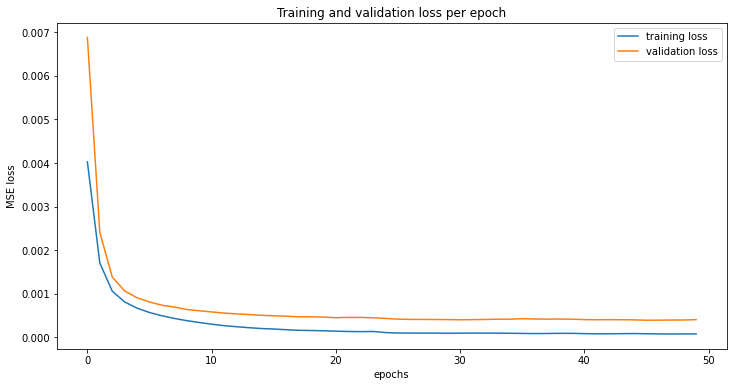

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(range(n_epochs), train_losses_epoch, label='training loss')
plt.plot(range(n_epochs), val_losses_epoch, label='validation loss')
plt.xlabel("epochs")
plt.ylabel("MSE loss")
plt.title("Training and validation loss per epoch")
plt.legend()
plt.savefig(f'{RESULT_FOLDER}/train-test-loss_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}', bbox_inches='tight')
plt.show()

# Testing

In [91]:
# get first I/O-sequence of test dataset for visualizing a prediction
for batch in data_module.test_dataloader():
    img_test = batch["input_img_sequence"]
    pr_test = batch["input_pr_sequence"]
    y_test = batch["output_sequence"]
    break

if CUDA:
    img_test = img_test.cuda()
    pr_test = pr_test.cuda() 
    y_test = y_test.cuda()

print(img_test.shape, pr_test.shape, y_test.shape)

torch.Size([1, 10, 1, 54, 96]) torch.Size([1, 10, 2]) torch.Size([1, 2, 60])


In [92]:
criterion = nn.MSELoss()

# make one prediction for visualization
with torch.no_grad():
    y_pred = loaded_model((img_test, pr_test))
    loss = criterion(y_pred, y_test)

    # clean up tensor and round results to visually compare predicted sequence
    a = y_pred.squeeze(0)[0].tolist()
    a = [round(num, 4) for num in a]

    b = y_test.squeeze(0)[0].tolist()
    b = [round(num, 4) for num in b]

    print(f'predicted pitch: {a}\nreal pitch:\t {b}')
    print("loss:", round(loss.item(), 6))

# squeeze out batch size and convert into cpu format for plotting
pr_test.squeeze(0).shape
input_sequence = pr_test.squeeze(0).cpu()
input_sequence = torch.transpose(input_sequence, 0, 1)
output_sequence = y_test.squeeze(0).cpu()
predicted_sequence = y_pred.squeeze(0).cpu()
input_sequence.shape, output_sequence.shape, predicted_sequence.shape

predicted pitch: [-0.0505, -0.0424, -0.0097, -0.0372, -0.0563, 0.0035, 0.0154, -0.0183, -0.115, -0.1307, -0.106, -0.086, -0.0911, -0.0397, -0.0021, -0.0013, -0.0492, -0.0626, -0.053, -0.0116, -0.0422, -0.0715, -0.0808, -0.0783, -0.1387, -0.1136, -0.0659, -0.0384, -0.0226, -0.0364, -0.0131, -0.014, -0.0267, -0.0392, -0.0046, -0.0328, -0.0138, 0.0234, 0.0301, 0.0256, -0.0046, 0.0055, 0.0015, 0.0865, -0.001, 0.0033, 0.0067, 0.0196, 0.0025, -0.0008, 0.0352, 0.0075, 0.0111, 0.0055, 0.0238, 0.006, 0.0404, 0.0329, 0.0275, 0.0307]
real pitch:	 [-0.031, -0.0089, 0.0059, -0.0252, -0.0355, 0.0103, 0.0275, -0.0065, -0.096, -0.1347, -0.115, -0.0883, -0.0894, -0.0333, 0.0056, -0.0015, -0.0473, -0.0611, -0.0573, -0.0053, -0.0343, -0.0649, -0.084, -0.0923, -0.1362, -0.1295, -0.0741, -0.0429, -0.0205, -0.0441, -0.016, -0.0129, -0.037, -0.032, 0.0031, -0.0398, -0.014, 0.0107, 0.0299, 0.0208, -0.0005, -0.0052, -0.0099, 0.0817, -0.0006, 0.0055, 0.0049, 0.0098, -0.0043, -0.0131, 0.0271, 0.0083, -0.0064, 0.

(torch.Size([2, 10]), torch.Size([2, 60]), torch.Size([2, 60]))

### Prediction vs. real on first test I/O-sequence

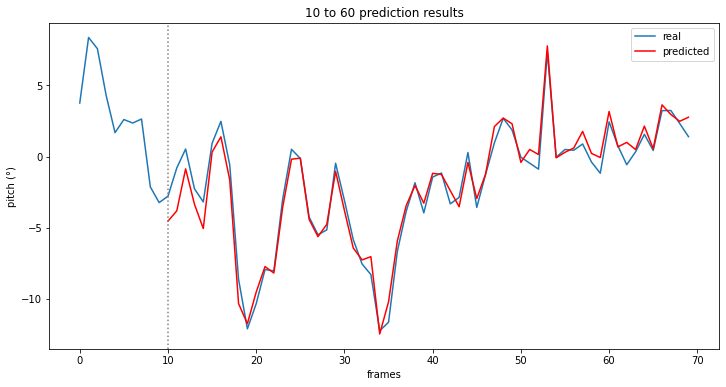

In [93]:
frames = np.arange(0, FRAMES_IN+FRAMES_OUT)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(frames, torch.cat((input_sequence[0].apply_(denorm_pr), output_sequence[0].apply_(denorm_pr))), label="real")
ax.plot(frames[FRAMES_IN:], predicted_sequence[0].apply_(denorm_pr), color="red", label='predicted')
plt.axvline(x=FRAMES_IN, color='grey', linestyle='dotted')
ax.set_xlabel('frames')
ax.set_ylabel('pitch (°)')
ax.set_title(f'{FRAMES_IN} to {FRAMES_OUT} prediction results')
plt.legend()
plt.savefig(f'{RESULT_FOLDER}/1ep_pitch-prediction_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}', bbox_inches='tight')
plt.show()

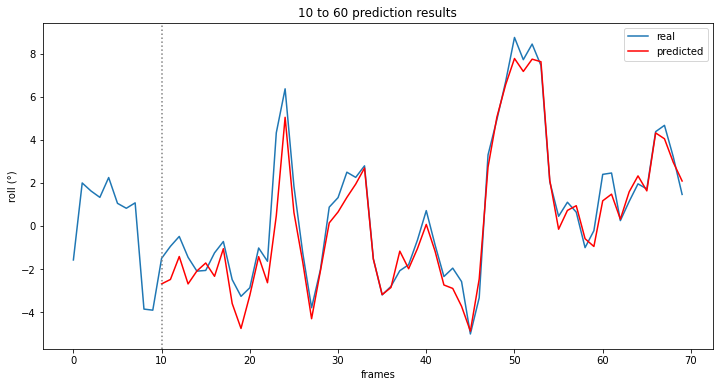

In [94]:
frames = np.arange(0, FRAMES_IN+FRAMES_OUT)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(frames, torch.cat((input_sequence[1].apply_(denorm_pr), output_sequence[1].apply_(denorm_pr))), label="real")
ax.plot(frames[FRAMES_IN:], predicted_sequence[1].apply_(denorm_pr), color="red", label='predicted')
plt.axvline(x=FRAMES_IN, color='grey', linestyle='dotted')
ax.set_xlabel('frames')
ax.set_ylabel('roll (°)')
ax.set_title(f'{FRAMES_IN} to {FRAMES_OUT} prediction results')
plt.legend()
plt.savefig(f'{RESULT_FOLDER}/1ep_roll-prediction_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}', bbox_inches='tight')
plt.show()

### Inference time

In [95]:
current = os.path.dirname(os.path.realpath(''))
parent = os.path.dirname(current)
sys.path.append(parent)  

# del sys.modules["notebooks.data_loaders.utils"]
from notebooks.data_loaders.utils import Utilities

total, inference = Utilities.inference_time(loaded_model, (img_test, pr_test), repetitions=10000, cuda=False)
print(f"total execution time for 10.000 predictions: {np.sum(total)}")
print(f"Inference time for 10.000 predictions:\t {inference}")

sum = 0
for p in loaded_model.parameters():
    sum += p.numel()

print(f"Total trainable parameters:\t {sum}")

total execution time for 10.000 predictions: 37976.949373960495
Inference time for 10.000 predictions:	 3.7976949373960496
Total trainable parameters:	 217741272


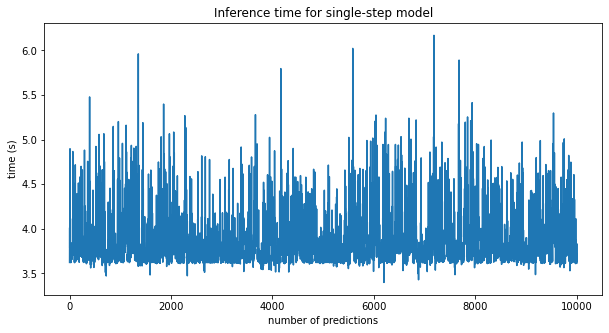

In [96]:
plt.figure(figsize=(10,5))
plt.plot(total)
plt.ylabel("time (s)")
plt.xlabel("number of predictions")
plt.title("Inference time for single-step model")
plt.savefig(f'{RESULT_FOLDER}/inference_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}', bbox_inches='tight')
plt.show()

### Full test loop

In [97]:
predictions = []
labels = []

with torch.no_grad():
    for batch in tqdm(data_module.test_dataloader()):
        img_test = batch["input_img_sequence"]
        pr_test = batch["input_pr_sequence"]
        y_test = batch["output_sequence"]

        if CUDA:
            img_test = img_test.cuda()
            pr_test = pr_test.cuda() 

        output = loaded_model((img_test, pr_test))

        # squeeze out batch size which is = 1 for test dataset
        predictions.append(output.cpu().squeeze(0))
        labels.append(y_test.squeeze(0))

  0%|          | 0/35748 [00:00<?, ?it/s]

In [98]:
# Predictions[0] = tensor object
# Predictions[0][0] = pitch value
# Predictions[0][1] = roll value

pitch_predictions = []
roll_predictions = []

pitch_label = []
roll_label = []

for i in range(len(predictions)):
    pitch_predictions.append(predictions[i][0])
    roll_predictions.append(predictions[i][1])
    pitch_label.append(labels[i][0])
    roll_label.append(labels[i][1])

pitch_predictions[0].shape, roll_predictions[0].shape, pitch_label[0].shape, roll_label[0].shape

(torch.Size([60]), torch.Size([60]), torch.Size([60]), torch.Size([60]))

### Average loss-per-frame over all datapoints

In [99]:
# function that returns a list with loss-values per frame
def loss_per_frame(predicted_sequence, real_sequence):
    loss_per_frame = []
    criterion = nn.MSELoss()
    if predicted_sequence.shape != real_sequence.shape:
        return loss_per_frame
    for i in range(len(predicted_sequence)):
        loss = criterion(predicted_sequence[i], real_sequence[i])
        loss_per_frame.append(loss.item())
    return loss_per_frame

In [100]:
# calculate mean loss per frame over all test data
total = len(pitch_predictions)
pitch_total = np.zeros(FRAMES_OUT, dtype=np.float64)
roll_total = np.zeros(FRAMES_OUT, dtype=np.float64)

for i in tqdm(range(len(pitch_predictions))):
    pitch_lpf = loss_per_frame(pitch_predictions[i], pitch_label[i])
    roll_lpf = loss_per_frame(roll_predictions[i], roll_label[i])
    pitch_total += pitch_lpf
    roll_total += roll_lpf

pitch_lpf_mse = pitch_total / total
roll_lpf_mse = roll_total / total

  0%|          | 0/35748 [00:00<?, ?it/s]

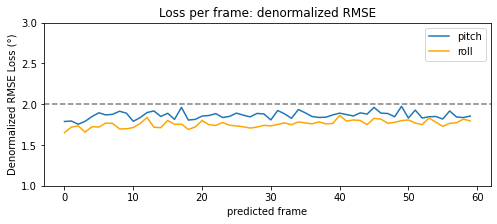

In [101]:
pitch_lpf_rmse = np.sqrt(pitch_lpf_mse)
roll_lpf_rmse = np.sqrt(roll_lpf_mse)
denorm = lambda x: denorm_pr(x)
vfunc = np.vectorize(denorm)
plt.figure(figsize=(8, 3))
plt.plot(vfunc(pitch_lpf_rmse), label='pitch')
plt.plot(vfunc(roll_lpf_rmse), color='orange', label='roll')
plt.axhline(y=2, color='gray', linestyle='--')
plt.xlabel('predicted frame')
plt.ylabel('Denormalized RMSE Loss (°)')
plt.yticks(np.arange(1,3.5,0.5))
plt.title('Loss per frame: denormalized RMSE')
plt.legend()
plt.savefig(f'{RESULT_FOLDER}/LPF-denorm-RMSE_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}', bbox_inches='tight')
plt.show()

### MSE results pitch

In [102]:
n = len(pitch_predictions)
loss0_tensor = torch.zeros(FRAMES_OUT)
criterion = nn.MSELoss()

loss = []
loss0 = []

total = 0
total0 = 0

for i in range(n):
    error = criterion(pitch_label[i], pitch_predictions[i]).item()
    error0 = criterion(pitch_label[i], loss0_tensor).item()
    loss.append(denorm_pr(math.sqrt(error)))
    loss0.append(denorm_pr(math.sqrt(error)))
    total += error
    total0 += error0
    

mse = round(total/n, 5)
rmse = round(math.sqrt(total/n), 4)
mse0 = round(total0/n, 5)
rmse0 = round(math.sqrt(total0/n), 4)

np.save(f"{TEST_RESULT_FOLDER}/pitch_denormalized_error_{FRAMES_IN}in_{FRAMES_OUT}out", loss)
np.save(f"{TEST_RESULT_FOLDER}/pitch_zero_error_{FRAMES_IN}in_{FRAMES_OUT}out", loss0)

print("Pitch prediction")
print("   MSE:", mse)
print("   RMSE:", rmse)
print(f"   RMSE denorm: {round(denorm_pr(rmse), 2)}°")
print("Zero prediction")
print("   MSE 0:", mse0)
print("   RMSE 0:", rmse0)
print(f"   RMSE denorm: {round(denorm_pr(rmse0), 2)}°")
print("Improvement on zero prediction:")
print("   MSE delta%:", round(mse0/mse*100, 2), "%")
print("   RMSE delta%:", round(rmse0/rmse*100, 2), "%")

Pitch prediction
   MSE: 0.00043
   RMSE: 0.0207
   RMSE denorm: 1.86°
Zero prediction
   MSE 0: 0.00494
   RMSE 0: 0.0703
   RMSE denorm: 6.33°
Improvement on zero prediction:
   MSE delta%: 1148.84 %
   RMSE delta%: 339.61 %


### MSE results roll

In [103]:
n = len(pitch_predictions)
loss0_tensor = torch.zeros(FRAMES_OUT)
criterion = nn.MSELoss()

n = len(pitch_predictions)
loss0_tensor = torch.zeros(FRAMES_OUT)
criterion = nn.MSELoss()

loss = []
loss0 = []

total = 0
total0 = 0

for i in range(n):
    error = criterion(roll_label[i], roll_predictions[i]).item()
    error0 = criterion(roll_label[i], loss0_tensor).item()
    loss.append(denorm_pr(math.sqrt(error)))
    loss0.append(denorm_pr(math.sqrt(error)))
    total += error
    total0 += error0
    

mse = round(total/n, 5)
rmse = round(math.sqrt(total/n), 4)
mse0 = round(total0/n, 5)
rmse0 = round(math.sqrt(total0/n), 4)

np.save(f"{TEST_RESULT_FOLDER}/roll_denormalized_error_{FRAMES_IN}in_{FRAMES_OUT}out", loss)
np.save(f"{TEST_RESULT_FOLDER}/roll_zero_error_{FRAMES_IN}in_{FRAMES_OUT}out", loss0)

print("Roll prediction")
print("   MSE:", mse)
print("   RMSE:", rmse)
print(f"   RMSE denorm: {round(denorm_pr(rmse), 2)}°")
print("Zero prediction")
print("   MSE 0:", mse0)
print("   RMSE 0:", rmse0)
print(f"   RMSE denorm: {round(denorm_pr(rmse0), 2)}°")
print("Improvement on zero prediction:")
print("   MSE delta%:", round(mse0/mse*100, 2), "%")
print("   RMSE delta%:", round(rmse0/rmse*100, 2), "%")

Roll prediction
   MSE: 0.00038
   RMSE: 0.0195
   RMSE denorm: 1.76°
Zero prediction
   MSE 0: 0.00682
   RMSE 0: 0.0826
   RMSE denorm: 7.43°
Improvement on zero prediction:
   MSE delta%: 1794.74 %
   RMSE delta%: 423.59 %


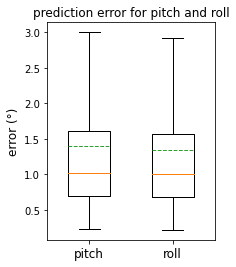

In [104]:
fig, ax = plt.subplots(figsize=(3,4))
pitch_error = np.load(f"{TEST_RESULT_FOLDER}/pitch_denormalized_error_{FRAMES_IN}in_{FRAMES_OUT}out.npy")
roll_error = np.load(f"{TEST_RESULT_FOLDER}/roll_denormalized_error_{FRAMES_IN}in_{FRAMES_OUT}out.npy")
ax.boxplot([pitch_error, roll_error], showfliers=False, widths=(0.5), showmeans=True, meanline=True)
ax.set_ylabel("error (°)", fontsize=12)
ax.set_xticks([1,2], ["pitch", "roll"], fontsize=12)
ax.set_title("prediction error for pitch and roll", fontsize=12)
plt.savefig(f'{RESULT_FOLDER}/error_boxplot_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}', bbox_inches='tight')

### Dotted episode performance

In [105]:
# load dotted episode
filename = "../../3dmodel/dotted_episode/"
data = []
labels = json.load(open(filename+"labels_0.json"))
df = pd.DataFrame(labels)
df = df.transpose()

df.rename(columns = {0:'pitch', 1:'roll'}, inplace=True)
df = df.astype({"pitch": float, "roll": float})
df['pitch'] = df['pitch'].apply(lambda x : norm_pr(x))
df['roll'] = df['roll'].apply(lambda x : norm_pr(x))

pr_test = df.iloc[0:FRAMES_IN]
pr_test = torch.Tensor(pr_test.to_numpy())
pr_test = pr_test.unsqueeze(0).cuda()

y_test = df.iloc[FRAMES_IN:FRAMES_IN+FRAMES_OUT].transpose()
y_test = torch.Tensor(y_test.to_numpy())
y_test = y_test.unsqueeze(0).cuda()
pr_test.shape, y_test.shape

(torch.Size([1, 10, 2]), torch.Size([1, 2, 60]))

In [106]:
dotted = []
for index in range(10):
    img = cv2.imread(filename + str(index) + ".png", cv2.IMREAD_GRAYSCALE)
    img = norm_pixel(img)
    dotted.append(torch.Tensor(img))

img_test = torch.stack(dotted)
img_test = img_test.unsqueeze(1).unsqueeze(0)
img_test = img_test.cuda()
img_test.shape

torch.Size([1, 10, 1, 54, 96])

In [107]:
# make one prediction for visualization
with torch.no_grad():
    y_pred = loaded_model((img_test, pr_test))

    # clean up tensor and round results to visually compare predicted sequence
    a = y_pred.squeeze(0)[0].tolist()
    a = [round(num, 4) for num in a]

    b = y_test.squeeze(0)[0].tolist()
    b = [round(num, 4) for num in b]

    print(f'predicted pitch: {a}\nreal pitch:\t {b}')

# squeeze out batch size and convert into cpu format for plotting
pr_test.squeeze(0).shape
input_sequence = pr_test.squeeze(0).cpu()
input_sequence = torch.transpose(input_sequence, 0, 1)
output_sequence = y_test.squeeze(0).cpu()
predicted_sequence = y_pred.squeeze(0).cpu()
input_sequence.shape, output_sequence.shape, predicted_sequence.shape

predicted pitch: [0.1291, 0.0046, 0.1357, 0.0562, 0.0876, -0.0245, 0.049, 0.0467, 0.0282, 0.0618, -0.006, 0.1286, 0.085, 0.0358, 0.1124, -0.0068, 0.0804, 0.0571, 0.1503, 0.1102, -0.0308, 0.022, 0.0078, -0.0126, 0.1051, 0.0915, 0.0569, 0.0257, 0.0798, 0.0455, -0.0066, 0.0632, 0.0882, -0.0174, -0.0854, -0.0499, 0.0141, 0.0022, 0.0199, 0.0215, 0.0797, 0.0418, 0.0268, -0.0336, -0.0661, 0.0353, 0.0462, -0.0036, 0.0125, -0.0252, -0.0445, 0.0002, -0.0804, 0.0432, -0.0185, 0.047, 0.0541, -0.0464, -0.0729, -0.0483]
real pitch:	 [0.0295, -0.0037, 0.1525, 0.0912, 0.0933, -0.0128, 0.095, 0.1625, 0.1036, 0.0774, 0.0955, 0.0615, 0.1166, -0.1029, -0.039, -0.0965, 0.115, 0.0672, 0.1892, 0.1413, 0.0972, 0.0782, -0.0112, 0.0431, 0.1098, 0.081, 0.0346, 0.0441, 0.0603, 0.0499, -0.0585, 0.0075, 0.0952, -0.1104, -0.1677, -0.1942, 0.0601, 0.1967, 0.1765, 0.1818, 0.1645, 0.2538, 0.2093, 0.1261, -0.0085, 0.1973, 0.0156, 0.0242, 0.059, 0.1047, -0.0406, 0.0331, -0.1455, 0.0176, 0.0285, 0.1294, 0.1163, 0.0226, 0.

(torch.Size([2, 10]), torch.Size([2, 60]), torch.Size([2, 60]))

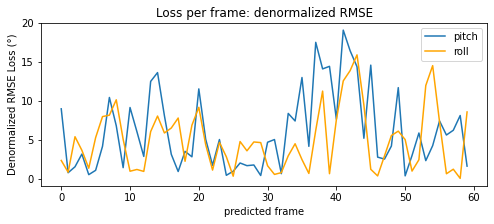

In [108]:
pitch_lpf_mse = loss_per_frame(output_sequence[0], predicted_sequence[0])
roll_lpf_mse = loss_per_frame(output_sequence[1], predicted_sequence[1])
pitch_lpf_rmse = np.sqrt(pitch_lpf_mse)
roll_lpf_rmse = np.sqrt(roll_lpf_mse)
denorm = lambda x: denorm_pr(x)
vfunc = np.vectorize(denorm)
plt.figure(figsize=(8, 3))
plt.plot(vfunc(pitch_lpf_rmse), label='pitch')
plt.plot(vfunc(roll_lpf_rmse), color='orange', label='roll')
plt.xlabel('predicted frame')
plt.ylabel('Denormalized RMSE Loss (°)')
plt.title('Loss per frame: denormalized RMSE')
plt.legend()
plt.savefig(f'{RESULT_FOLDER}/dots_LPF-denorm-RMSE_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}', bbox_inches='tight')

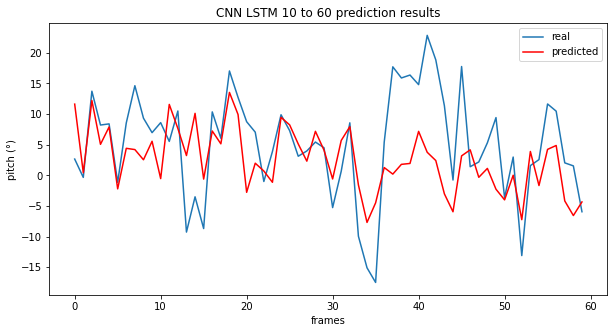

In [109]:
frames = np.arange(0,FRAMES_OUT)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(output_sequence[0].apply_(denorm_pr), label="real")
ax.plot(predicted_sequence[0].apply_(denorm_pr), color="red", label='predicted')
ax.set_xlabel('frames')
ax.set_ylabel('pitch (°)')
ax.set_title(f'CNN LSTM {FRAMES_IN} to {FRAMES_OUT} prediction results')
plt.legend()
plt.savefig(f'{RESULT_FOLDER}/dots_pitch-prediction_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}', bbox_inches='tight')
plt.show()

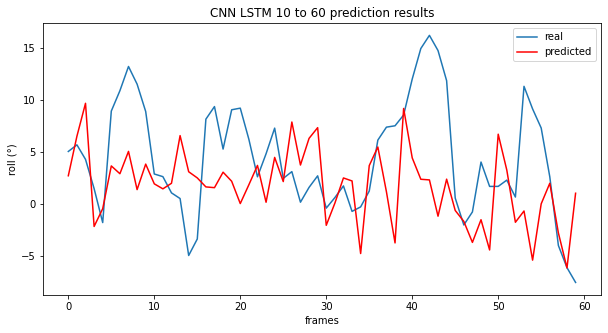

In [110]:
frames = np.arange(0,FRAMES_OUT)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(output_sequence[1].apply_(denorm_pr), label="real")
ax.plot(predicted_sequence[1].apply_(denorm_pr), color="red", label='predicted')
ax.set_xlabel('frames')
ax.set_ylabel('roll (°)')
ax.set_title(f'CNN LSTM {FRAMES_IN} to {FRAMES_OUT} prediction results')
plt.legend()
plt.savefig(f'{RESULT_FOLDER}/dots_roll-prediction_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}', bbox_inches='tight')
plt.show()

In [111]:
criterion = nn.MSELoss()

p = criterion(y_pred.squeeze(0)[0], y_test.squeeze(0)[0])
r = criterion(y_pred.squeeze(0)[1], y_test.squeeze(0)[1])
p = round(math.sqrt(p.item()), 4)
r = round(math.sqrt(r.item()), 4)
print("Prediction error on dotted episode")
print(f"   Pitch RMSE denorm: {round(denorm_pr(p), 2)}°")
print(f"   Roll RMSE denorm: {round(denorm_pr(r), 2)}°")

Prediction error on dotted episode
   Pitch RMSE denorm: 7.82°
   Roll RMSE denorm: 6.31°
